### Recommendations for: https://www.kaggle.com/CooperUnion/anime-recommendations-database

A recommender system, or a recommendation system, is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. They are primarily used in commercial applications.

Recommender systems are utilized in a variety of areas and are most commonly recognized as playlist generators for video and music services like Netflix, YouTube and Spotify, product recommenders for services such as Amazon, or content recommenders for social media platforms such as Facebook and Twitter. These systems can operate using a single input, like music, or multiple inputs within and across platforms like news, books, and search queries. There are also popular recommender systems for specific topics like restaurants and online dating. Recommender systems have also been developed to explore research articles and experts, collaborators, and financial services.

# Import

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import pandas_summary as ps

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVD, SlopeOne, NMF
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
folder = '/kaggle/input/anime-recommendations-database/'
anime_df = pd.read_csv(folder+'anime.csv')
rate_df = pd.read_csv(folder+'rating.csv')

In [ ]:
print('anime: ', anime_df.shape)
print('rating: ', rate_df.shape)

In [ ]:
anime_df.head()

In [ ]:
rate_df.head()

In [ ]:
full_df = rate_df.merge(anime_df, how='left', left_on=['anime_id'], right_on=['anime_id'])
df = full_df[full_df['rating_x'] != -1]
df.head()

In [ ]:
full_df.shape, df.shape

# EDA

In [ ]:
dfs = ps.DataFrameSummary(full_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

In [ ]:
dfs = ps.DataFrameSummary(df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

In [ ]:
data = df['rating_x'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
layout = dict(title = 'Distribution Of {} anime-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
data = df.groupby('user_id')['rating_x'].count().clip(upper=250)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 250,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 250)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
data = df.groupby('anime_id')['rating_x'].count().clip(upper=250)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 250,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings Per anime_id (Clipped at 250)',
                   xaxis = dict(title = 'Ratings Per anime_id'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
data = df.groupby('genre')['rating_x'].count().clip(upper=250)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 250,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Anime (Clipped at 250)',
                   xaxis = dict(title = 'Number of Ratings Per Anime'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Clip it

In [ ]:
min_anime_ratings = 250
filter_anime = df['anime_id'].value_counts() > min_anime_ratings
filter_anime = filter_anime[filter_anime].index.tolist()

min_user_ratings = 250
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['anime_id'].isin(filter_anime)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

In [ ]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_new[['user_id', 'anime_id', 'rating_x']], reader)

# Cross Validation & Algorithm selection

In [ ]:
benchmark = []
for algorithm in [SVD(biased=False), SlopeOne(), NMF()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [ ]:
%time
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

### SVD algorithm showed the best test rmse

For any user, you can predict ratings that he has not yet set. You need to train the model so that it gives the smallest errors for already known models.

Prediction is the scalar product of a vector for a user and a vector for an object.

With this approach, much less model parameters need to be trained.

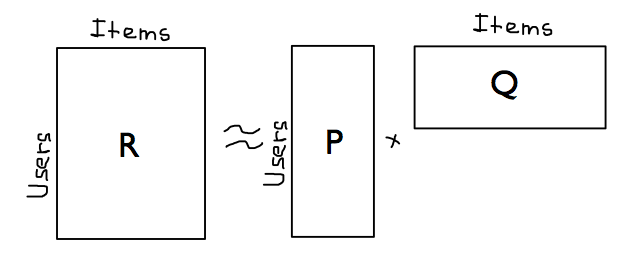

SVD cannot be directly applied, since there are a lot of missing values (more precisely, you can somehow fill them out, but the quality is not very good).
Therefore, the optimization problem is formulated according to well-known estimates $K$:

$$ min_{p, q} \sum_{u,i \in K} (r_{ui} - q_i^T p_u)^2 + \lambda (||q_i||^2 + ||p_u||^2)$$

In [ ]:
%time
algo = SVD(biased=False)
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

# Fit

In [ ]:
%time
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

In [ ]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_ = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_['Iu'] = df_.uid.apply(get_Iu)
df_['Ui'] = df_.iid.apply(get_Ui)
df_['err'] = abs(df_.est - df_.rui)

In [ ]:
df_.head()

# Predict

In [ ]:
%time
data_pred = []
for row in full_df[full_df['rating_x'] == -1].itertuples():
    tmp_pred = algo.predict(row[1], row[2])
    data_pred.append((tmp_pred[0], tmp_pred[1], round(tmp_pred[3], 2)))
data_pred = pd.DataFrame(data_pred, columns=['user_id', 'anime_id', 'rating'])

In [ ]:
data_pred.head()

In [ ]:
data_pred.to_csv('submission.csv', index=False)